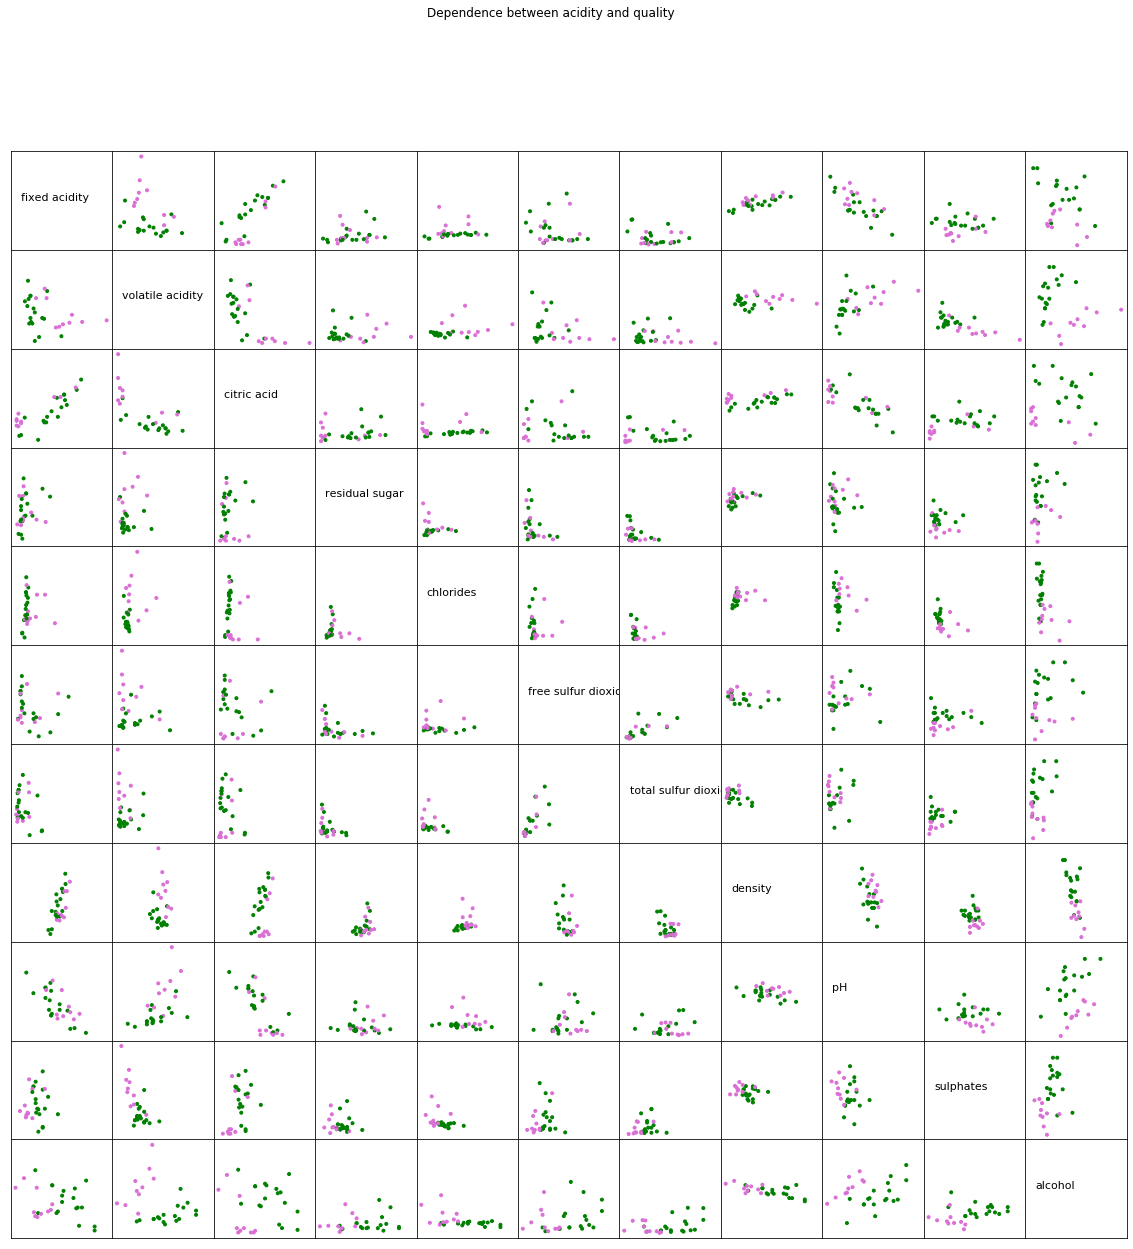

In [9]:
#V.1

import matplotlib.pyplot as plt
import pandas as pd

white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def plot_scatter_matrix(wine_data: pd.DataFrame, good_threshold: int, bad_threshold: int, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce graphs which shows dependence between
    every two factors.
    """
    assert good_threshold > bad_threshold, "Please, enter good_treshold sctrictly > than bad_treshold"
    q = wine_data['quality']    

    labels = wine_data.columns[:-1]
    assert len(labels) >=2, "there have to be at least 2 labels ti build dependence"
    f, axarr = plt.subplots(len(labels), len(labels), figsize=(20, 20))
    f.suptitle('Dependence between acidity and quality')
    f.subplots_adjust(wspace=0, hspace=0)

    k = 0
    for x in [wine_data[label] for label in labels]:
        j = 0
        for y in [wine_data[label] for label in labels]:
            axarr[k][j].set_xticks([])
            axarr[k][j].set_yticks([])
            if k == j:
                axarr[k][j].text(0.1, 0.5, labels[k], fontsize=11)
            else:
                colors = [('orchid' if q[i]<= bad_threshold else ('green' if q[i]>=good_threshold else 'None'))\
                          for i in range(wine_data.shape[0])]
                axarr[k][j].scatter(x, y, marker='.', c=colors)
            j+=1
        k+=1
    plt.savefig('fig.png') if save_plot else 0
    return
        
    
plot_scatter_matrix(red_df, 8, 3, False)

# Important chemical factors: volatile acidity, sulfates, alcohol. 
# Basically we can divide almost strictly bad and good wines considering them.

In [17]:
print('Reading .csv data')
white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def feature_scaling(x: pd.DataFrame):
    means, maxs, mins = {}, {}, {}
    for feature in x.columns[:-1]:
        means[feature] = sum(x[feature]) / len(x[feature])
        maxs[feature] = max(x[feature])
        mins[feature] = min(x[feature])
    
    scaled_x = x.copy(deep=True)
    for feature in scaled_x.columns[:-1]:
        for j in range(len(scaled_x[feature])):
            scaled_x.loc[j, feature] = (x[feature][j] - means[feature]) / (maxs[feature] - mins[feature])
    return scaled_x

print('Feature scaling is on.')
red_df = feature_scaling(red_df)
print('Data scaled.')

Reading .csv data
Feature scaling is on.
Data scaled.


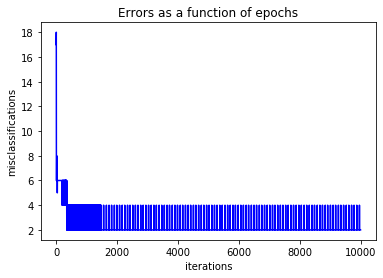

b = 7.960134058041815, w1 = -3.132902580358165, w2 = 2.8197664583372712, x2 = 0.01-x1*-1.11
y(x=0) = 0.014138029708209508


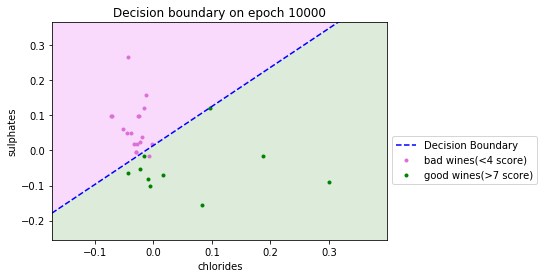

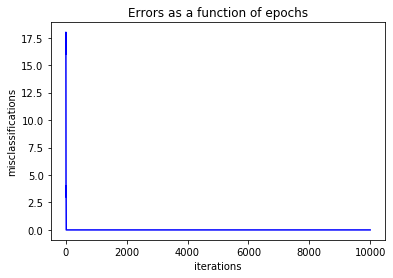

b = 8.088190085308943, w1 = -0.7594680500714295, w2 = 1.7528137357707951, x2 = -0.05-x1*-0.43
y(x=0) = -0.05031343805059906


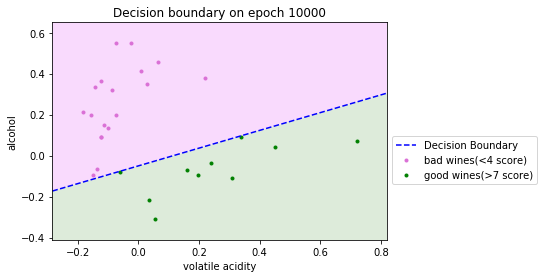

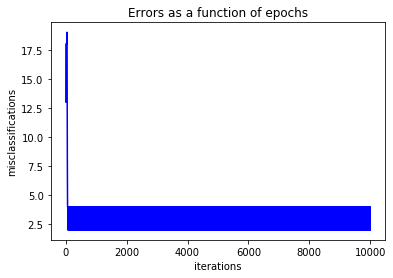

b = 8.001175906484498, w1 = -0.046560781745990196, w2 = -0.04423056909344138, x2 = 0.03-x1*1.05
y(x=0) = 0.026585832120175536


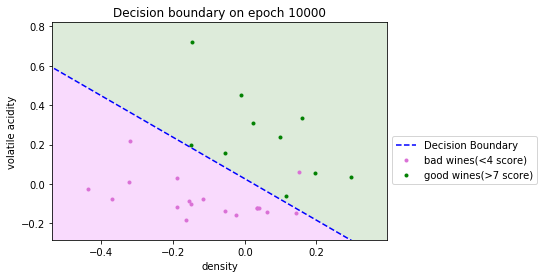

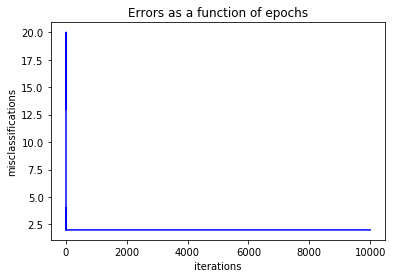

b = 8.00275713084472, w1 = -0.42745452038299087, w2 = -0.398596900379413, x2 = 0.01-x1*1.07
y(x=0) = 0.006917090529545766


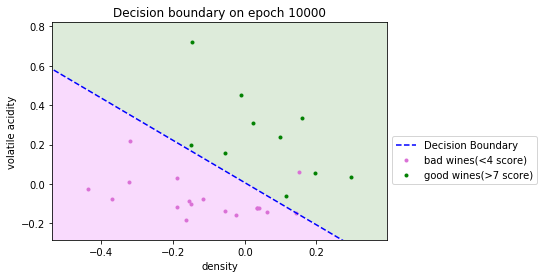

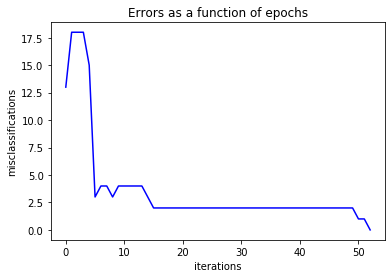

b = 8.023555354655802, w1 = -1.3181613018288483, w2 = 1.633721486086619, x2 = -0.01-x1*-0.81
y(x=0) = -0.014418219296500528


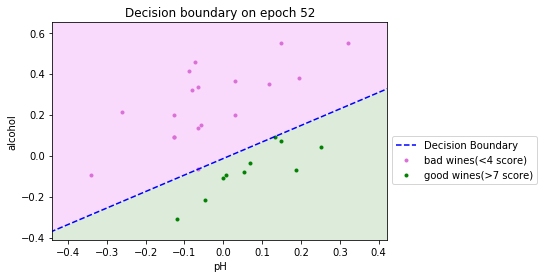

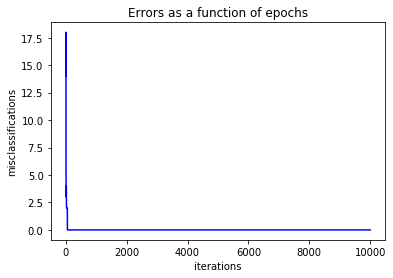

b = 8.02616472754633, w1 = -1.07079571224286, w2 = 1.2896594812535134, x2 = -0.02-x1*-0.83
y(x=0) = -0.020288089938980618


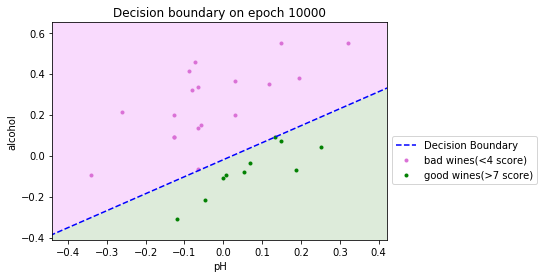

In [58]:
# V.2

import random
random.seed(1777)


def dot(a: list, b: list) -> float:
    """
    Scalar product of 2 vectors a and b
    """
    assert len(a) == len(b), "Vectors must be equal length!"
    return sum([a[i] * b[i] for i in range(len(a))])

class Perceptron(object):

    def __init__(self, threshold, learning_rate =0.4, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs 
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        return

    def error(self, y: list, d: list) -> int:
        return sum(abs(d-y))

    def do_step(self, x, y, d):
        """
        update weights for each row once
        """
        for row in range(len(x)):
            y[row] = int(dot(x[row], self.w) + self.bias >= self.threshold)
            error = d[row] - y[row]
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * error * x[row][col]
            self.bias += self.learning_rate * error
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return

    def train(self, x: list, d: list): 
        """
        train perceptron on received data
        x - received data (matrix, row - one specific wine)
        d - desired output (good(1) or bad(0) wines good=(quality>threshold))
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))] # x1w1 + x2w2 + b = threshold 
        self.bias = random.random()
        y = [int(random.random() > 0.5) for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        if self.epochs > 0:
            for _ in range(self.epochs):
                self.do_step(x, y, d)
        else:
            while self.res[-1][1] > 0:
                self.do_step(x, y, d)
        return


def plot_performance(performance, wine_data, good_thresh, bad_thresh, factors: list, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    if epoch < 0 or epoch > performance[-1][0]:
        print(f'epoch was : {epoch}')
        epoch = performance[-1][0]
    plt.figure(1)
    errors = [performance[i][1]  for i in range(len(performance))]
    epochs = [performance[i][0]  for i in range(len(performance))]
    plt.plot(epochs, errors, c='b')
    plt.xlabel('iterations')
    plt.ylabel('misclassifications')
    plt.title('Errors as a function of epochs')
    plt.show()

    b = performance[epoch][3]
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    assert w2 != 0, "w2 = 0"
    print(f'b = {b}, w1 = {w1}, w2 = {w2}, x2 = {round((good_thresh - b)/w2,2)}-x1*{round(w1/w2,2)}') # x1w1 + x2w2 + b =8
    print(f'y(x=0) = {(good_thresh - b) / w2}')
    f1 = [i for i in range(-50, 50)]
    f2 = [ (good_thresh - b - w1 * f1[j]) / w2 for j in range(len(f1))]
    plt.figure(2)
    plt.xlim(min(wine_data[factors[0]].values)-0.1, max(wine_data[factors[0]].values)+0.1)
    plt.ylim(min(wine_data[factors[1]].values)-0.1, max(wine_data[factors[1]].values)+0.1)
    plt.plot(f1, f2, linestyle='--', color='b', label='Decision Boundary')
   
    goods = wine_data[wine_data['quality'] >= good_thresh]
    bads = wine_data[wine_data['quality'] <= bad_thresh]
    xg, yg = goods[factors[0]].values, goods[factors[1]].values
    xb, yb = bads[factors[0]].values, bads[factors[1]].values

    # count good dots and define how to fill the field
    right_color, left_color = (0.976, 0.854, 0.992), (0.866, 0.921, 0.854)
    righter = 0
    for xi, yi in zip(xg, yg):
        if (good_thresh - b - w1 * xi) / w2 < yi:
            righter += 1
    if righter > len(xg) / 2:
        right_color, left_color = (0.866, 0.921, 0.854), (0.976, 0.854, 0.992)
    

    plt.fill_between(f1, f2, 100, facecolor=left_color)
    plt.fill_between(f1, f2, -100, facecolor=right_color)
    plt.scatter(xg, yg, marker='.', c='orchid', label=f'bad wines(<{bad_thresh+1} score)')
    plt.scatter(xb, yb, marker='.', c='green', label=f'good wines(>{good_thresh-1} score)')
    plt.title(f'Decision boundary on epoch {epoch}')
    plt.xlabel(factors[0]) 
    plt.ylabel(factors[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    return

def prepare_data_and_train(wine_data: pd.DataFrame, learning_rate, \
                           factors: list, wines_threshs: list, epochs: int):
    perceptron = Perceptron(wines_threshs[1], learning_rate, epochs)
    part = wine_data[wine_data.quality.isin(wines_threshs)]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= wines_threshs[1]).astype(int)
    perceptron.train(x, d)
    plot_performance(perceptron.res, part, wines_threshs[1], wines_threshs[0], factors, perceptron.current_epoch)
    return


prepare_data_and_train(red_df, 0.1, ['chlorides', 'sulphates'], [3, 8], 10000)
prepare_data_and_train(red_df, 0.1, ['volatile acidity', 'alcohol'], [3, 8], 10000)
prepare_data_and_train(red_df, 0.01, ['density', 'volatile acidity'], [3, 8], 10000)
prepare_data_and_train(red_df, 0.1, ['density', 'volatile acidity'], [3, 8], 10000)
prepare_data_and_train(red_df, 0.1, ['pH', 'alcohol'], [3, 8], 0)
prepare_data_and_train(red_df, 0.1, ['pH', 'alcohol'], [3, 8], 10000)



# V.2 end

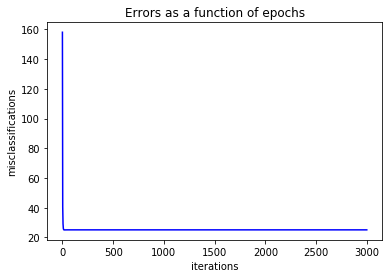

b = 5.428170084534892, w1 = 9.244176417304798, w2 = -9.52085392361597, x2 = -0.27-x1*-0.97
y(x=0) = -0.2701259714830643


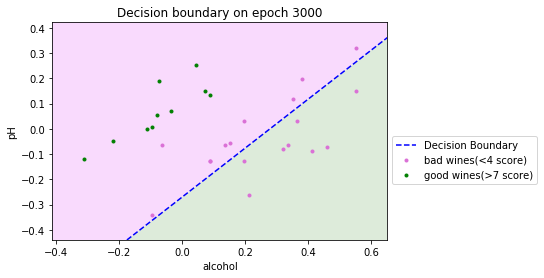

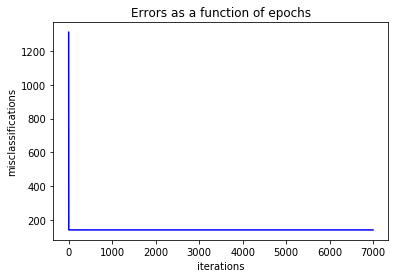

b = 6.554786052071059, w1 = 3.207431679003619, w2 = -2.76299284473951, x2 = -0.16-x1*-1.16
y(x=0) = -0.16113467277940613


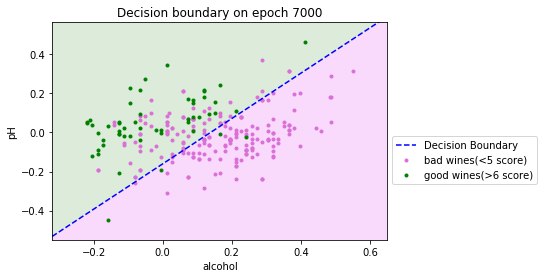

In [59]:
# V.3

class Adaline(object):

    def __init__(self, threshold, learning_rate=0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        return
 
    def error(self, y: list, d: list) -> float:
        r = 0
        for i in range(len(d)):
            r += (d[i] - y[i]) * (d[i] - y[i])
        r = r / 2
        return r

    def do_step_batch(self, x, y, d):
        """
        update weights for each row once (batch)
        """
        updates = [0 for i in range(len(x[0]))]
        bias_update = 0
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                updates[col] += self.learning_rate * error * x[row][col]
            bias_update += self.learning_rate * error
        self.bias +=  bias_update
        for col in range(len(x[row])):
            self.w[col] += updates[col]
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
    
    def do_step_online(self, x, y, d):
        """
        update weights for each row once (batch)
        """        
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * error * x[row][col]
            self.bias += self.learning_rate * error
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
          
    def train(self, x: list, d: list, online=True, reinitialize_weights=True):
        """
        train adaline on received data
        x - received data (matrix, row - one specific wine)
        d - desired output
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        if reinitialize_weights:
            self.w = [random.random() for i in range(len(x[0]))]
            self.bias = random.random()
        y = [random.random() * 10 for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        step = self.do_step_online if online else self.do_step_batch
        if self.epochs > 0:
            for _ in range(self.epochs):
                step(x, y, d)
        else:
            while self.res[-1][1] > 0:
                step(x, y, d)
        return
    
    def predict(self, x):
        return dot(self.w, x) + self.bias
    
    
def prepare_data_and_train_ada(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[wine_data.quality.isin(wines_threshs)]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    plot_performance(ada.res, part, wines_threshs[1], wines_threshs[0], factors, ada.current_epoch)
    return


# learning_rate, online = 0.04, False
learning_rate, online = 0.4, True

# showtime
# prepare_data_and_train_ada(red_df, 0.4, ['alcohol', 'pH'], [3, 8], 50)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [3, 8], 50)

prepare_data_and_train_ada(red_df, learning_rate, ['alcohol', 'pH'], [3, 8], 3000, online)
prepare_data_and_train_ada(red_df, learning_rate, ['alcohol', 'pH'], [4, 7], 7000, online)



In [55]:
# V.4

# holdout method
# If you have very few training data points, the holdout method can
# be expensive in terms of data usage and it may be better to use
# something like k-fold cross-validation.


def holdout(wine_data: pd.DataFrame, limits, train_part=0.8):
    wine_data = wine_data[wine_data.quality.isin(limits)]
    train_amount = int(wine_data.shape[0] * train_part)
    print(f'train amonunt = {train_amount}')
    print(f'valid amonunt = {wine_data.shape[0] - train_amount}')
    training_df = wine_data.sample(n=train_amount)
    validation_df = wine_data.drop(training_df.index)
    return (training_df, validation_df)

(training_df, validation_df) = holdout(red_df, [3, 8])
ada = Adaline(8, 0.4, 10000)
tr, val = training_df[training_df.quality.isin([3, 8])], validation_df[validation_df.quality.isin([3, 8])]
tr.index, val.index = range(len(tr)), range(len(val))
x, val_x = tr[['pH', 'alcohol']].values, val[['pH', 'alcohol']].values
d, val_d = tr['quality'], val['quality']
ada.train(x, d)
print(f'x == {x}')
for j in range(len(val_x)):
    print(f'prediction i = {j} : {ada.predict(val_x[j])}, error = {val_d[j] - ada.predict(val_x[j])}')


    
def k_fold(wine_data: pd.DataFrame, k=3, shuffle=False):
    if shuffle:
        wine_data = wine_data.sample(frac=1, random_state=1, axis=0)
    folds = []
    rest = wine_data
    amount = int(wine_data.shape[0] / k)
    for i in range(k-1):
        training_temp = rest.sample(n=amount)
        folds.append(training_temp)
        rest = rest.drop(training_temp.index) 
    folds.append(rest)
    
    res = []
    for i in range(k):
        res.append([folds[i], wine_data.drop(folds[i].index)]) # (trainig, validation)
    return res


k_folds = k_fold(red_df[:10], 3)
k_folds = k_fold(red_df[:10], 4, True)



train amonunt = 22
valid amonunt = 6
x == [[ 0.03061953  0.36569491]
 [ 0.13298174  0.08877183]
 [-0.04812063 -0.21892048]
 [ 0.03061953  0.19646414]
 [ 0.14872977  0.55031029]
 [ 0.00699748 -0.09584356]
 [ 0.06998961 -0.03430509]
 [ 0.1172337   0.35031029]
 [-0.12686078  0.19646414]
 [-0.07174267  0.4580026 ]
 [ 0.14872977  0.07338721]
 [ 0.19597386  0.38107952]
 [-0.06386866  0.13492567]
 [ 0.25109197  0.04261798]
 [-0.08749071  0.41184875]
 [-0.26071905  0.21184875]
 [ 0.32195811  0.55031029]
 [-0.12686078  0.08877183]
 [-0.33945921 -0.09584356]
 [-0.06386866  0.33492567]
 [-0.05599464  0.15031029]
 [ 0.18809985 -0.07276663]]
prediction i = 0 : 1.7277469058560002, error = 6.272253094144
prediction i = 1 : -1.8780541720755761, error = 4.878054172075576
prediction i = 2 : -1.115669402502665, error = 4.1156694025026646
prediction i = 3 : 3.4241013424838456, error = 4.575898657516154
prediction i = 4 : -0.10363330218709993, error = 8.1036333021871
prediction i = 5 : -0.979936748069259, 